### __Notebook to verify that looking at temperature amplitude ratio is interesting for a diffusive problem in the monodirectional case__ ###


In [151]:
#Necessary imports

import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk 
from pyheatmy import * 
from pyheatmy.time_series_multiperiodic import time_series_multiperiodic

from sklearn import linear_model
from pyheatmy.core import *
import scipy

In [152]:
#On commence par créer un signal d'entrée grace à la classe time_series_multiperiodic, que l'on forcera dans la classe Synthetic_Molonari ensuite

T_riv = time_series_multiperiodic("multi_periodic")

#On regarde des variations de température sur une année, on définit une période journalière, et une période annuelle

T_MOY_ANNUELLE = 12 + ZERO_CELSIUS #°C, représente l'offset commun de nos signaux de température

T_AMP_ANNUELLE = 6 #°C, représente l'amplitude de variation de température annuelle

T_AMP_JOURNALIERE = 1 #°C, représente l'amplitude de variation de température journalière

P_an = 12 #Période annuelle en mois

P_jour = 24 #Période journalière, en heures

t_debut = (2024, 4, 15, 8, 0, 0)  # (year, month, day, hour, minute, second)
t_fin = (2024, 4, 20, 8, 0, 0)
dt = int(NSECINHOUR / 4)  #On se place dans le cas d'un point de mesure toutes les heures (à moduler en fonction de l'intervale temporel considéré)

In [153]:
#Ensuite, on commence par créer un objet synthetic_MOLONARI pour pouvoir utiliser ses méthodes (et en particulier accéder à son générateur de dates)

"""Conditions limites"""
# Température de la rivière
zeroT = ZERO_CELSIUS  #time_series works only with forcings in celsius. See if it is deeper in pyheatmy or not

T_riv_amp = 5
T_riv_offset = 20  + zeroT
nday = 3
P_T_riv = nday*NHOURINDAY*4*dt #monthly   period
# Température de l'aquifère
T_aq_amp = 0
T_aq_offset = 14 + zeroT
P_T_aq = -9999 # à mettre dans le init
# Pression différentielle
dH_amp = 0
dH_offset = 0.5 #1meter ?
P_dh = -9999 #14*24*4*dt


depth_sensors = [.1, .2, .3, .4]
Zbottom = 0.4

"""Bruit de mesure"""
sigma_meas_P = 0   # !! initial value = 0.001
sigma_meas_T = 0  # !! initial value = 0.1

print("dt={0:.1f}s".format(dt))

dt=900.0s


Initializing time series of synthetic_MOLONARI
param_time_dates: [(2024, 4, 15, 8, 0, 0), (2024, 4, 20, 8, 0, 0), 900]
param_dH_signal: [0, -9999, 0.5]
param_T_riv_signal: [5, 259200, 293.15]
param_T_aq_signal: [0, -9999, 287.15]
sigma_meas_P: 0
sigma_meas_T: 0
Entering Hydraulic head differential generation with amplitude 0, period of -9999, offset 0.5, dt 900 --> 
constant signal

Entering T_riv generation with amplitude 5, period of 259200, offset 293.15, dt 900 --> 
periodic signal



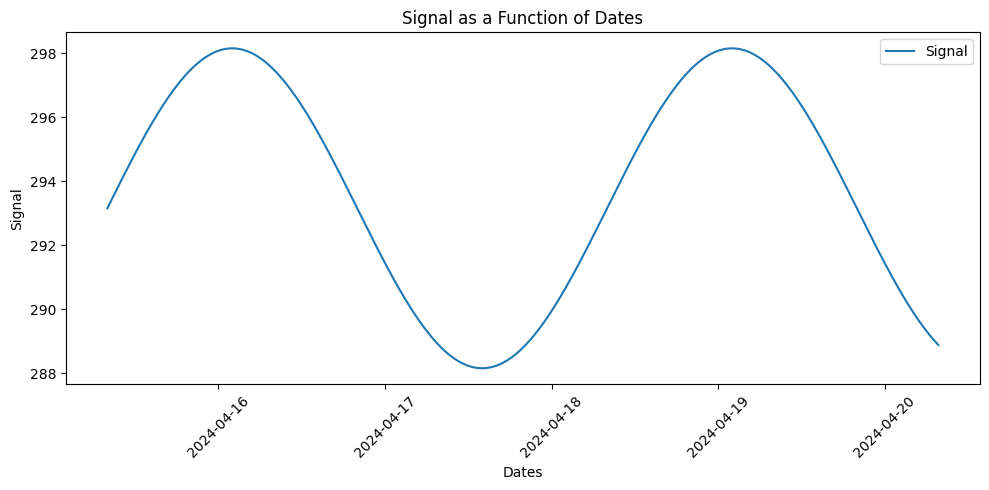

Entering T_aq generation with amplitude 0, period of -9999, offset 287.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [291.65       291.73180582 291.8135727  291.89526173 291.97683404
 292.05825078 292.13947322 292.2204627  292.30118067 292.38158871
 292.46164855 292.5413221  292.62057142 292.6993588  292.77764675
 292.85539799 292.93257554 293.00914264 293.08506287 293.16030009
 293.23481848 293.30858259 293.3815573  293.45370788 293.525
 293.59539972 293.66487353 293.73338837 293.80091164 293.86741118
 293.93285536 293.99721302 294.06045354 294.12254681 294.18346328
 294.24317396 294.30165043 294.35886486 294.41479001 294.46939928
 294.52266666 294.57456681 294.62507503 294.67416727 294.72182017
 294.76801105 294.81271792 294.85591952 294.89759526 294.93772533
 294.97629062 295.01327278 295.0486542  295.08241805 295.11454825
 295.14502951 295.17384733 295.20098799 295.22643857 295.25018695
 295.27222185 295.29253276 2

In [154]:
"""Reprise du code de dmo_genData pour créer un objet synthetic_MOLONARI"""
# un dictionnaire qui facilite le paramétrage avec des variables globales définies plus haut
time_series_dict_user1 = {
    "offset":.0,
    "depth_sensors":depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, dH_offset], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_amp, P_T_riv, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": sigma_meas_P,
    "sigma_meas_T": sigma_meas_T, #float
}
# instanciation du simulateur de données
emu_observ_test_user1 = synthetic_MOLONARI.from_dict(time_series_dict_user1)


In [155]:
#On print l'attribut date de l'objet créé pour voir si la forme convient 

print(f"Dates : {emu_observ_test_user1._dates}")

Dates : [datetime.datetime(2024, 4, 15, 8, 0)
 datetime.datetime(2024, 4, 15, 8, 15)
 datetime.datetime(2024, 4, 15, 8, 30)
 datetime.datetime(2024, 4, 15, 8, 45)
 datetime.datetime(2024, 4, 15, 9, 0)
 datetime.datetime(2024, 4, 15, 9, 15)
 datetime.datetime(2024, 4, 15, 9, 30)
 datetime.datetime(2024, 4, 15, 9, 45)
 datetime.datetime(2024, 4, 15, 10, 0)
 datetime.datetime(2024, 4, 15, 10, 15)
 datetime.datetime(2024, 4, 15, 10, 30)
 datetime.datetime(2024, 4, 15, 10, 45)
 datetime.datetime(2024, 4, 15, 11, 0)
 datetime.datetime(2024, 4, 15, 11, 15)
 datetime.datetime(2024, 4, 15, 11, 30)
 datetime.datetime(2024, 4, 15, 11, 45)
 datetime.datetime(2024, 4, 15, 12, 0)
 datetime.datetime(2024, 4, 15, 12, 15)
 datetime.datetime(2024, 4, 15, 12, 30)
 datetime.datetime(2024, 4, 15, 12, 45)
 datetime.datetime(2024, 4, 15, 13, 0)
 datetime.datetime(2024, 4, 15, 13, 15)
 datetime.datetime(2024, 4, 15, 13, 30)
 datetime.datetime(2024, 4, 15, 13, 45)
 datetime.datetime(2024, 4, 15, 14, 0)
 dateti

Creating a multi-periodic signal, with the following period: [[24, 'h']] and the following amplitude: [1]
periods : [86400]


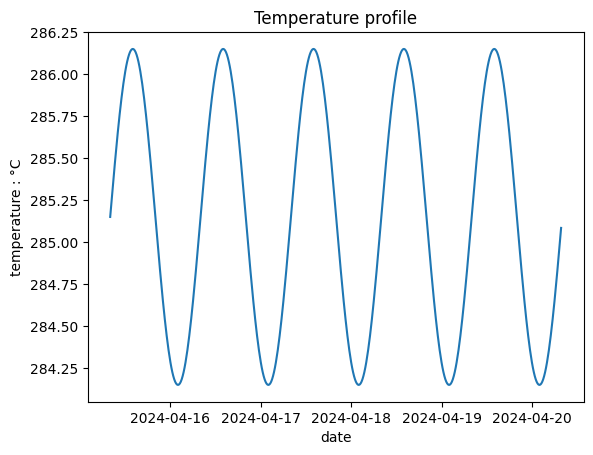

In [156]:
#On utilise le jeu de date précédent pour créer un signal de température multipériodique 

'''T_riv.create_multiperiodic_signal([T_AMP_ANNUELLE, T_AMP_JOURNALIERE], [[P_an, 'm'], [P_jour, 'h']], emu_observ_test_user1._dates, dt,
                                   offset=T_MOY_ANNUELLE)'''

# simple signal
T_riv.create_multiperiodic_signal([T_AMP_JOURNALIERE], [[P_jour, 'h']], emu_observ_test_user1._dates, dt,
                                   offset=T_MOY_ANNUELLE)

T_riv.plot() #On affiche le signal de température créé

In [157]:
#On force la variable T_riv dans l'objet emu_observ_test_user1

emu_observ_test_user1._T_riv = T_riv.multi_periodic[1][:]

#Puis on applique les méthodes _generate_Shaft_Temp_series et _generate_perturb_Shaft_Temp_series pour changer les valeurs dépendante du nouveau T_riv

emu_observ_test_user1._generate_Shaft_Temp_series()
emu_observ_test_user1._generate_perturb_Shaft_Temp_series()
emu_observ_test_user1._generate_perturb_T_riv_dH_series()

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [285.65       285.69905235 285.74789464 285.79631774 285.84411428
 285.8910796  285.93701257 285.98171652 286.025      286.06667767
 286.10657107 286.14450936 286.18033009 286.21387986 286.24501501
 286.27360221 286.29951905 286.32265456 286.34290965 286.3601976
 286.37444437 286.38558896 286.39358365 286.39839419 286.4
 286.39839419 286.39358365 286.38558896 286.37444437 286.3601976
 286.34290965 286.32265456 286.29951905 286.27360221 286.24501501
 286.21387986 286.18033009 286.14450936 286.10657107 286.06667767
 286.025      285.98171652 285.93701257 285.8910796  285.84411428
 285.79631774 285.74789464 285.69905235 285.65       285.60094765
 285.55210536 285.50368226 285.45588572 285.4089204  285.36298743
 285.31828348 285.275      285.23332233 285.19342893 285.15549064
 285.11966991 285.08612014 285.05498499 285.02639779 285.00048095
 284.97734544 284.95709035 284.9398024  284.92555563 284.91441104
 284

In [158]:
#on génère un objet colonne à partir de l'objet emu_observ_test_user1

name ="Couche en sable"
zLow = Zbottom
moinslog10IntrinK = 11
n = 0.1
lambda_s = 2 # test cas purement advectif
rhos_cs = 4e6

# modèle une couche
layers_list= layersListCreator([(name, zLow, moinslog10IntrinK, n, lambda_s, rhos_cs)])

print(f"Layers list: {layers_list}")

# on utilise les mesures générées précédemment dans les init "dH_measures" et "T_measures"
col_dict = {
	"river_bed": 1., 
    "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"offset": .0,
    "dH_measures": emu_observ_test_user1._molonariP_data,
    "T_measures": emu_observ_test_user1._molonariT_data,
    "sigma_meas_P": 0, #float  !! initial value = 0.01
    "sigma_meas_T": 0, #float  !! initial value = 0.1
}
col = Column.from_dict(col_dict,verbose=True)

Layers list: [Couche en sable : ends at 0.4 m. Parametres(moinslog10IntrinK=11, n=0.1, lambda_s=2, rhos_cs=4000000.0)]
Column created with success
Number of time steps: 480
Time step in days: 0.010394965277777777
T_riv: [285.15       285.21540313 285.28052619 285.34509032 285.40881905
 285.47143947 285.53268343 285.59228869 285.65       285.70557023
 285.75876143 285.80934582 285.85710678 285.90183981 285.94335334
 285.98146961 286.0160254  286.04687274 286.07387953 286.09693013
 286.11592583 286.13078528 286.14144486 286.14785892 286.15
 286.14785892 286.14144486 286.13078528 286.11592583 286.09693013
 286.07387953 286.04687274 286.0160254  285.98146961 285.94335334
 285.90183981 285.85710678 285.80934582 285.75876143 285.70557023
 285.65       285.59228869 285.53268343 285.47143947 285.40881905
 285.34509032 285.28052619 285.21540313 285.15       285.08459687
 285.01947381 284.95490968 284.89118095 284.82856053 284.76731657
 284.70771131 284.65       284.59442977 284.54123857 284.490

In [159]:
nb_cells=20 # nombre de cellules, une tous les 5 centimètres 

col._compute_solve_transi_multiple_layers(layers_list, nb_cells, verbose=True)

--- Compute Solve Transi ---
One layer : moinslog10IntrinK = 11, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0
Solving the flow with intrinsec permeability 1e-11, and permeability 9.810000000000001e-05
Done.


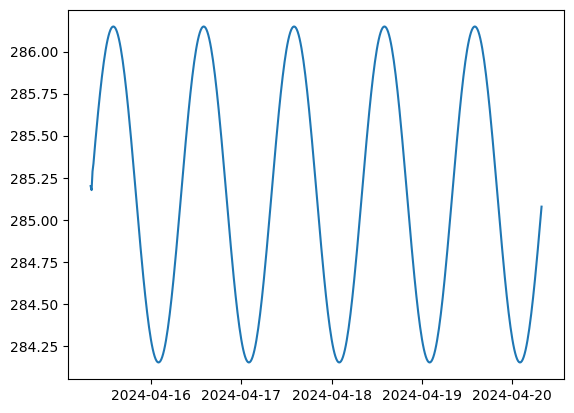

In [160]:
#On vérifie que les températures ont bien été modifiées dans l'objet column (en particulier que la température à profondeur nulle est bien celle de la rivière)

plt.plot(emu_observ_test_user1._dates, col._temperatures[0,:])
plt.show()

In [161]:
print(f"La matrice de température a pour shape : {col._temperatures.shape}, abscisse = température aux 20 cellules, ordonnée = température à chaque pas de temps")

La matrice de température a pour shape : (20, 480), abscisse = température aux 20 cellules, ordonnée = température à chaque pas de temps


In [162]:
#On définit une fonction pour pouvoir compiler en faisant varier la valeur de la charge (et donc le régime infiltration ou exfiltration vers la 
#rivière) ainsi que la valeur de la porosité (et donc le régime de diffusion de la chaleur - majoritairement diffusif ou advectif)

def profil_temperature(offset_H, moinslog10IntrinK): 
    """Conditions limites"""
    # Température de la rivière
    zeroT = ZERO_CELSIUS  #time_series works only with forcings in celsius. See if it is deeper in pyheatmy or not

    T_riv_amp = 5
    T_riv_offset = 20  + zeroT
    nday = 3
    P_T_riv = nday*NHOURINDAY*4*dt #monthly   period
    # Température de l'aquifère
    T_aq_amp = 0
    T_aq_offset = 14 + zeroT
    P_T_aq = -9999 # à mettre dans le init
    # Pression différentielle
    dH_amp = 0
    P_dh = -9999 #14*24*4*dt


    depth_sensors = [.1, .2, .3, .4]
    Zbottom = 0.4

    """Bruit de mesure"""
    sigma_meas_P = 0.001
    sigma_meas_T = 0.1
    time_series_dict_user1 = {
    "offset":.0,
    "depth_sensors":depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, offset_H], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_amp, P_T_riv, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": sigma_meas_P,
    "sigma_meas_T": sigma_meas_T, 
}
    emu_observ_test_user1 = synthetic_MOLONARI.from_dict(time_series_dict_user1)
    
    T_riv.create_multiperiodic_signal([T_AMP_ANNUELLE, T_AMP_JOURNALIERE], [[P_an, 'm'], [P_jour, 'h']], emu_observ_test_user1._dates, dt,
                                   offset=T_MOY_ANNUELLE)
    emu_observ_test_user1._T_riv = T_riv.multi_periodic[1][:]

    emu_observ_test_user1._generate_Shaft_Temp_series()
    emu_observ_test_user1._generate_perturb_Shaft_Temp_series()
    emu_observ_test_user1._generate_perturb_T_riv_dH_series()
    name ="Couche en sable"
    zLow = Zbottom
    n = 0.1
    lambda_s = 2 # test cas purement advectif
    rhos_cs = 4e6

    # modèle une couche
    layers_list= layersListCreator([(name, zLow, moinslog10IntrinK, n, lambda_s, rhos_cs)])

    print(f"Layers list: {layers_list}")

    # on utilise les mesures générées précédemment dans les init "dH_measures" et "T_measures"
    col_dict = {
        "river_bed": 1., 
        "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
        "offset": .0,
        "dH_measures": emu_observ_test_user1._molonariP_data,
        "T_measures": emu_observ_test_user1._molonariT_data,
        "sigma_meas_P": 0.01, #float
        "sigma_meas_T": 0.1, #float
    }
    col = Column.from_dict(col_dict,verbose=False)
    nb_cells=20 # nombre de cellules, une tous les 5 centimètres 

    col._compute_solve_transi_multiple_layers(layers_list, nb_cells, verbose=True)
    return col._temperatures



In [163]:
# Argument : la matrice, liste des profondeur
# Sortie : liste des amplitudes
def amplitude(T):
    amplitude_list = []
    for j in range(len(T[0,:])):
        T_max = max(T[:,j])
        T_min = min(T[:,j])
        A = (T_max - T_min) / 2
        amplitude_list.append(A)
    return amplitude_list


# Retourne ln(rapport des amplitudes) en fonction de la profondeur
def ln_amp(T):
    amplitude_list = amplitude(T)
    amplitude_array = np.array(amplitude_list)
    ln_rapport_amplitude = np.log( amplitude_array / amplitude_array[0] )
    return ln_rapport_amplitude


# Trace le ln_temp(T) en fonction de depths
def plot_ln_amp(depths, T):
    y = ln_amp(T)
    plt.plot(depths, y)
    plt.title("Logarithme du rapport des amplitudes")
    plt.xlabel("profondeur (unit)")
    plt.ylabel("ln(A_z / A_0)")
    plt.show()


# Renvoie l'instance de régression linéaire des données (profondeur, ln(rapport amplitudes))
def linear_regression(depths, T):
    y = ln_amp(T)
    return scipy.stats.linregress(depths, y)


# Trace l'interpolation linéaire en imprimant le coefficient d'exactitude
def plot_linear_regression(depths, T):
    # assert len(T) == lent(depths), "a temperature measure must be assigned to a single depth"
    X = np.array(depths).reshape(-1,1)
    Y = ln_amp(T)
    Lr = linear_regression(depths, T)
    Pearson_coefficient = Lr.rvalue
    slope = Lr.slope
    intercept = Lr.intercept
    lm = linear_model.LinearRegression()
    lm.fit(X, Y)
    plt.scatter(X, Y, color="r", marker="o", s=30)
    y_pred = lm.predict(X)
    plt.plot(X, y_pred, color="k")
    plt.xlabel("profondeur (unit)")
    plt.ylabel("ln(A_z / A_0)")
    plt.title("Régression linéaire sur le rapport des logarithmes des amplitudes")
    plt.figtext(.6, .8, "y = " + str(slope) + "x + " + str(intercept))
    plt.figtext(.6, .7, "Pearson coefficient : " + str(Pearson_coefficient))
    plt.show()


# Mosaïque des différentes courbes en fonction des valeurs de K (list_K = liste de ces valeurs)
# T est la liste des matrices de températures pour différentes valeurs de K
def plot_mosaic(depths, list_T, list_K):  
    # assert len(list_T[0]) == lent(depths), "a temperature measure must be assigned to a single depth"
    assert len(list_T) == len(list_K), 'The number of K values does not match the number a temperature matrices'
    n_rows = len(list_K)//2 + len(list_K)%2
    _, ax = plt.subplots(n_rows, ncols=2)
    X = np.array(depths).reshape(-1,1)
    for i in range(n_rows):
        for j in range(2):
            Y = ln_amp(list_T[2*i+j])
            Lr = linear_regression(depths, list_T[2*i+j])
            Pearson_coefficient = Lr.rvalue
            slope = Lr.slope
            intercept = Lr.intercept
            lm = linear_model.LinearRegression()
            lm.fit(X, Y)
            ax[i][j].scatter(X, Y, color="r", marker="o", s=30)
            y_pred = lm.predict(X)
            ax[i][j].plot(X, y_pred, color="k")
            ax[i][j].set_xlabel('profondeur (unit)')
            ax[i][j].set_ylabel('température')
            ax[i][j].set_title('Rapport des ln(A_z / A_0) avec K =' + str(list_K[2*i] + j), size = 10)   
            ax[i][j].legend(["Pearson coefficient : " + str(Pearson_coefficient)])


In [164]:
# test de plot_linear_regression
# Création d'un jeu de données arbitraire :

def test_plot_linear_regression():
    T = np.zeros((10,10))
    depths = [0.1 * i for i in range(10)]
    for i in range(10):
        for j in range(10):
            T[i,j] = np.sin(i) * np.exp(-j)

    plot_linear_regression(depths, T)

# test de plot_mosaic
# Création de 4 valeurs de K absurde

def test_plot_mosaic():
    T = np.zeros((10,10))
    depths = [0.1 * i for i in range(10)]
    list_K = range(1,5)
    list_T = [T for _ in range(4)]

    plot_mosaic(depths,list_T,list_K)


Initializing time series of synthetic_MOLONARI
param_time_dates: [(2024, 4, 15, 8, 0, 0), (2024, 4, 20, 8, 0, 0), 900]
param_dH_signal: [0, -9999, 0.05]
param_T_riv_signal: [5, 259200, 293.15]
param_T_aq_signal: [0, -9999, 287.15]
sigma_meas_P: 0.001
sigma_meas_T: 0.1
Entering Hydraulic head differential generation with amplitude 0, period of -9999, offset 0.05, dt 900 --> 
constant signal

Entering T_riv generation with amplitude 5, period of 259200, offset 293.15, dt 900 --> 
periodic signal



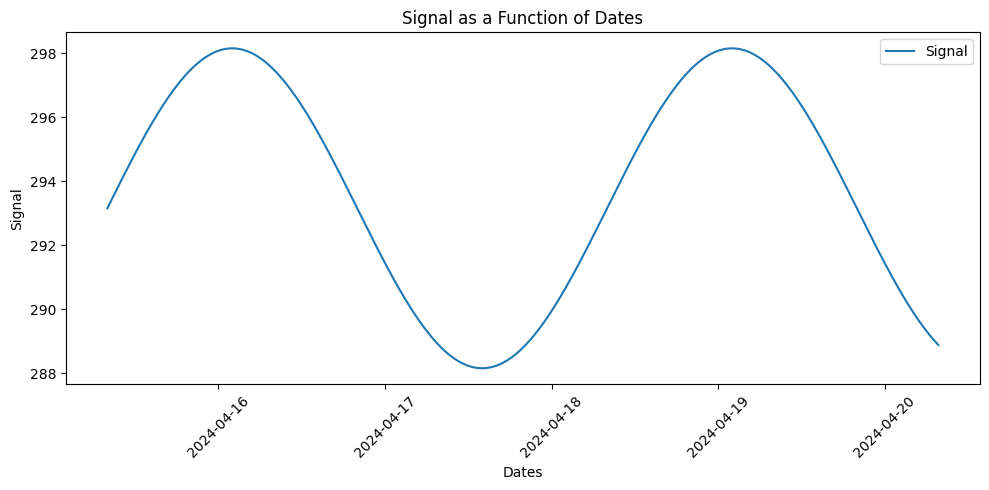

Entering T_aq generation with amplitude 0, period of -9999, offset 287.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [291.65       291.73180582 291.8135727  291.89526173 291.97683404
 292.05825078 292.13947322 292.2204627  292.30118067 292.38158871
 292.46164855 292.5413221  292.62057142 292.6993588  292.77764675
 292.85539799 292.93257554 293.00914264 293.08506287 293.16030009
 293.23481848 293.30858259 293.3815573  293.45370788 293.525
 293.59539972 293.66487353 293.73338837 293.80091164 293.86741118
 293.93285536 293.99721302 294.06045354 294.12254681 294.18346328
 294.24317396 294.30165043 294.35886486 294.41479001 294.46939928
 294.52266666 294.57456681 294.62507503 294.67416727 294.72182017
 294.76801105 294.81271792 294.85591952 294.89759526 294.93772533
 294.97629062 295.01327278 295.0486542  295.08241805 295.11454825
 295.14502951 295.17384733 295.20098799 295.22643857 295.25018695
 295.27222185 295.29253276 2

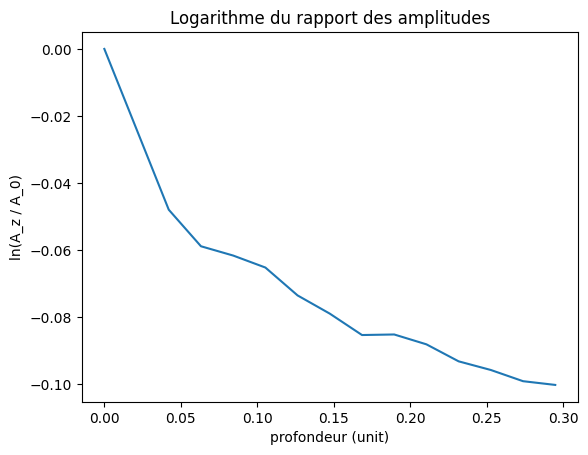

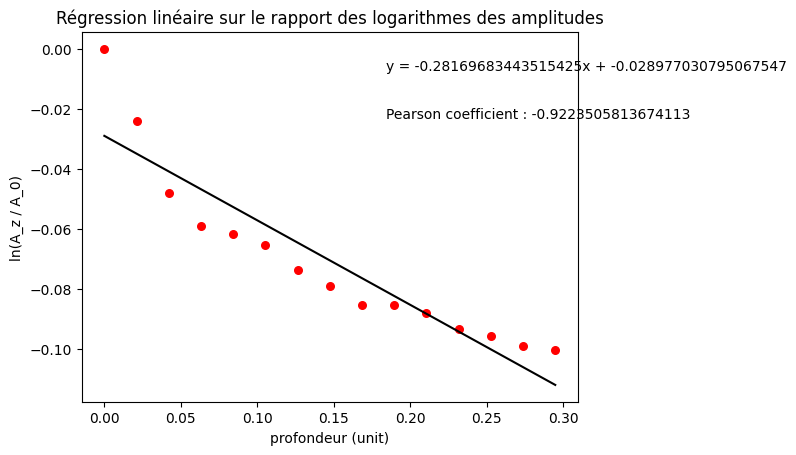

In [165]:
# On se place un jour aléatoire
# n_dt_in_day = int(NSECINDAY / dt)
# day = np.random.randint(0, len(emu_observ_test_user1._dates)-n_dt_in_day)

# On trace la température en fonction de la profondeur pour ce jour

offset_H = 0.05
moinslog10IntrinK = 10

profil_temp = profil_temperature(offset_H, moinslog10IntrinK)[:15,:]

depth_cells = np.linspace(0, 0.4, 20)
plot_ln_amp(depth_cells[0:15], np.transpose(profil_temp))
plot_linear_regression(depth_cells[0:15], np.transpose(profil_temp))
